# ETL for Amazon

## Web Scraping

In [1]:
!pip install requests
!pip install pandas
!pip install bs4

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests


In [14]:
def get_data(pageNo):
    headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/109.0",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.5",
    "Accept-Encoding": "gzip, deflate, br",
    "Connection": "keep-alive",
    "Upgrade-Insecure-Requests": "1",
    "Referer": "https://www.google.com/"
    }

    r = requests.get(f"https://www.amazon.in/gp/bestsellers/books?ie=UTF8&pg={pageNo}", headers=headers)
    content = r.content
    soup = BeautifulSoup(content)

    alls = []

    for d in soup.findAll('div', attrs = {'class': '_cDEzb_iveVideoWrapper_JJ34T'}):
        name = d.find("div", attrs = {'class': '_cDEzb_p13n-sc-css-line-clamp-1_1Fn1y'})
        author = d.find_all("div", attrs={'class':'_cDEzb_p13n-sc-css-line-clamp-1_1Fn1y'})
        rating = d.find("span", attrs={'class': 'a-icon-alt'})
        price = d.find("span", attrs={'class': '_cDEzb_p13n-sc-price_3mJ9Z'})
        # print(f"The details are {name}, {author}, {rating}, {price}")
        
        all1 = []

        if name is not None:
            all1.append(name.text)
        else:
            all1.append("unknown-product")

        if len(author)>1:
            all1.append(author[1].text)
        else:
            all1.append("unknown-author")

        if rating is not None:
            all1.append(rating.text)
        else:
            all1.append("unknown-rating")
            
        if price is not None:
            all1.append(price.text)
        else:
            all1.append("unknown-price")
        alls.append(all1)
    return alls
            
data_page_1 = get_data(1)
data_page_2 = get_data(2)

df1 = pd.DataFrame(data_page_1, columns=["Book Name", "Author", "Rating", "Price"])
df2 = pd.DataFrame(data_page_2, columns=["Book Name", "Author", "Rating", "Price"])

final_df = pd.concat([df1, df2], ignore_index=True)

def transform(df):
    df["Rating"] = df["Rating"].apply(lambda x: float(x.split(" out of 5 stars")[0]) if "out of 5 stars" in x else None)
    return df

transformed_df = transform(final_df)
transformed_df.to_csv("books_data.csv", index=False)

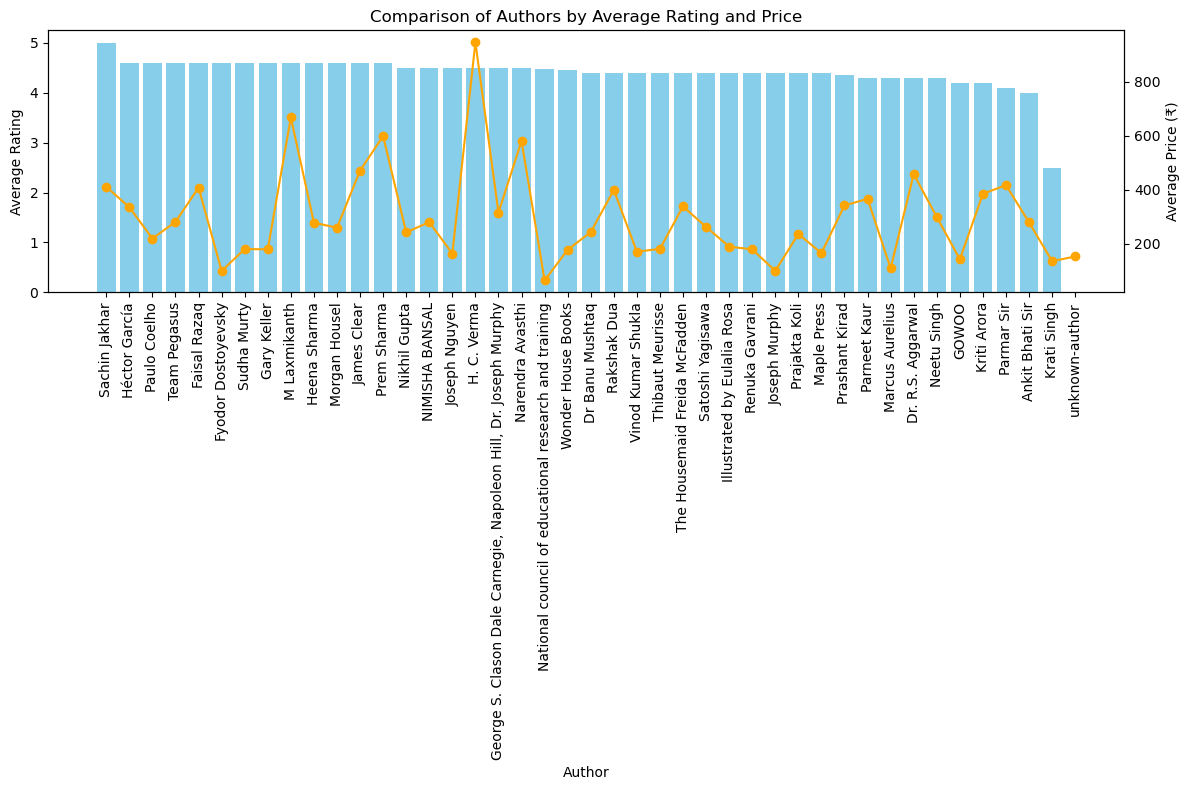

In [17]:
import matplotlib.pyplot as plt

grouped = transformed_df.groupby("Author").agg({"Rating": "mean", "Price": lambda x: pd.to_numeric(x.str.replace("₹", ""), errors='coerce').mean()})
grouped_sorted = grouped.sort_values("Rating", ascending=False)

# Create bar chart
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(grouped_sorted.index, grouped_sorted["Rating"], color='skyblue', label='Average Rating')
ax1.set_ylabel("Average Rating")
ax1.set_xlabel("Author")
ax1.set_xticks(np.arange(len(grouped_sorted.index)))
ax1.set_xticklabels(grouped_sorted.index, rotation=90)

ax2 = ax1.twinx()
ax2.plot(grouped_sorted.index, grouped_sorted["Price"], color='orange', label='Average Price', marker='o')
ax2.set_ylabel("Average Price (₹)")

# Title and layout
plt.title("Comparison of Authors by Average Rating and Price")
fig.tight_layout()
plt.savefig("author_rating_price_comparison.png", dpi=300, bbox_inches='tight')
plt.show()